# import the dependencies

In [1]:
import sys
from collections import Counter

import numpy as np
import pandas as pd

from tqdm import tqdm

import tensorflow as tf
from transformers import RobertaTokenizerFast


from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
from matplotlib import rcParams

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Available GPUs:", physical_devices)

Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Prepare data

In [3]:
all_data = pd.read_csv("../lstm_lo_steps_prediction/data/steps_combi_term_str.csv", delimiter=',')

# leave only unique terms
print(f"Count all terms: {len(all_data)}\n")
all_data = all_data.drop_duplicates(subset="comb_terms").reset_index(drop=True)
print(f"Count original terms: {len(all_data)}\n")

# shuffle the dataset
all_data = shuffle(all_data, random_state=33).reset_index(drop=True)

# filter out steps_lo that are more than 30
all_data = all_data[[steps_lo < 31 for steps_lo in all_data['steps_num_lo']]]

print(f"max steps count: {max(all_data['steps_num_lo'])}")
print(f"min steps count: {min(all_data['steps_num_lo'])}")

# make test/train split
x_train, x_test, y_train_, y_test_ = train_test_split(all_data["comb_terms"].tolist(),
                                                      all_data["steps_num_lo"].tolist(),
                                                      test_size=0.2, random_state=42)

# print(f"Count training samples: {len(y_train_)}")
print(f"Count testing samples: {len(y_test_)}")

Count all terms: 4163

Count original terms: 4163

max steps count: 30
min steps count: 0
Count testing samples: 721


In [4]:
print("Load additional dataset")
all_data = pd.read_csv("../lstm_lo_steps_prediction/data/steps_combi_term_str_v1_0-2.csv", delimiter=',')
all_data = pd.concat([all_data, pd.read_csv("../lstm_lo_steps_prediction/data/steps_combi_term_str_v1_3-5.csv", delimiter=',')])
all_data = pd.concat([all_data, pd.read_csv("../lstm_lo_steps_prediction/data/steps_combi_term_str_v1_6-8.csv", delimiter=',')])
all_data = pd.concat([all_data, pd.read_csv("../lstm_lo_steps_prediction/data/steps_combi_term_str_v1_9-11.csv", delimiter=',')])
all_data = pd.concat([all_data, pd.read_csv("../lstm_lo_steps_prediction/data/steps_combi_term_str_v1_12-14.csv", delimiter=',')])
all_data = pd.concat([all_data, pd.read_csv("../lstm_lo_steps_prediction/data/steps_combi_term_str_v1_15-17.csv", delimiter=',')])
all_data = pd.concat([all_data, pd.read_csv("../lstm_lo_steps_prediction/data/steps_combi_term_str_v1_18-19.csv", delimiter=',')])


# leave only unique terms
print(f"Count all terms: {len(all_data)}\n")
all_data = all_data.drop_duplicates(subset="comb_terms").reset_index(drop=True)
print(f"Count original terms: {len(all_data)}\n")

# shuffle the dataset
all_data = shuffle(all_data, random_state=33).reset_index(drop=True)

# filter out steps_lo that are more than 30
all_data = all_data[[steps_lo < 31 for steps_lo in all_data['steps_num_lo']]]

print(f"max steps count: {max(all_data['steps_num_lo'])}")
print(f"min steps count: {min(all_data['steps_num_lo'])}")

train_df_0 = pd.DataFrame({"steps_num_lo": y_train_, "comb_terms": x_train})
all_data = pd.concat([all_data, train_df_0])

x_train, y_train_ = all_data["comb_terms"].tolist(), all_data["steps_num_lo"].tolist()

print(f"Count training samples: {len(y_train_)}")

Load additional dataset
Count all terms: 44410

Count original terms: 43745

max steps count: 30
min steps count: 0
Count training samples: 40474


In [5]:
sequence_len = 512

tokenizer = RobertaTokenizerFast.from_pretrained("./fine_models_comb_str", max_len=sequence_len)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [6]:
x_train = [x_.replace(" ", "") for x_ in x_train]
x_test = [x_.replace(" ", "") for x_ in x_test]

train_df = pd.DataFrame({"term_str": x_train, "steps_lo": y_train_})
test_df = pd.DataFrame({"term_str": x_test, "steps_lo": y_test_})

label_encoder = {key_: [0.0] * 31 for key_ in range(31)}
for key_ in label_encoder.keys():
    label_encoder[key_][key_] = 1.0

def preprocess(example):
    # Tokenize the prompt
    tokenized_texts = tokenizer(example['term_str'].to_list(), truncation=True, padding='max_length', max_length=sequence_len, return_tensors="tf")
    labels = tf.convert_to_tensor([label_encoder[key_] for key_ in example["steps_lo"]])
    return tokenized_texts, labels


tokenized_train_data = preprocess(train_df)
tokenized_test_data = preprocess(test_df)

In [7]:
batch_size = 64

train_dataset = tf.data.Dataset.from_tensor_slices((dict(tokenized_train_data[0]), tokenized_train_data[1])).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((dict(tokenized_test_data[0]), tokenized_test_data[1])).batch(batch_size)

# Configure the model

In [12]:
from transformers import BertConfig

config = BertConfig(
    vocab_size=9,
    hidden_size=84,
    num_hidden_layers=2,
    num_attention_heads=6,
    intermediate_size=64,
    max_position_embeddings=sequence_len,
    num_labels=31
)

# vocab_size=30522,
# hidden_size=768,
# num_hidden_layers=12,
# num_attention_heads=12,
# intermediate_size=3072,
# hidden_act="gelu",
# hidden_dropout_prob=0.1,
# attention_probs_dropout_prob=0.1,
# max_position_embeddings=512,
# type_vocab_size=2,
# initializer_range=0.02,
# layer_norm_eps=1e-12,
# pad_token_id=0,
# position_embedding_type="absolute",
# use_cache=True,
# classifier_dropout=None,

In [13]:
from transformers import TFBertModel
from keras.layers import Dense, Input, Flatten, AveragePooling1D, Dropout
from keras.models import Model

bert = TFBertModel(config=config)
bert.build()

input_ids_in = Input(shape=(sequence_len,), name='input_ids', dtype='int32')
input_masks_in = Input(shape=(sequence_len,), name='attention_mask', dtype='int32')

embedding_layer = bert(input_ids_in, attention_mask=input_masks_in)[0]
outputs = AveragePooling1D(pool_size=50)(embedding_layer)
outputs = Flatten()(outputs)
outputs = Dropout(rate=0.1)(outputs)
outputs = Dense(units=31, activation="softmax")(outputs)
model = Model(inputs=[input_ids_in, input_masks_in], outputs=outputs)

In [14]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 tf_bert_model_1 (TFBertModel)  TFBaseModelOutputWi  130832      ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                         

# Train a language model

In [15]:
epochs = 15
history = model.fit(train_dataset, validation_data=test_dataset, epochs=epochs)

Epoch 1/15
633/633 [==============================] - 102s 155ms/step - loss: 2.7894 - accuracy: 0.1340 - val_loss: 2.5979 - val_accuracy: 0.1470
Epoch 2/15
633/633 [==============================] - 98s 155ms/step - loss: 2.6078 - accuracy: 0.1577 - val_loss: 2.5096 - val_accuracy: 0.1720
Epoch 3/15
633/633 [==============================] - 99s 156ms/step - loss: 2.5672 - accuracy: 0.1667 - val_loss: 2.5466 - val_accuracy: 0.1706
Epoch 4/15
633/633 [==============================] - 99s 156ms/step - loss: 2.5449 - accuracy: 0.1709 - val_loss: 2.5435 - val_accuracy: 0.1526
Epoch 5/15
633/633 [==============================] - 98s 155ms/step - loss: 2.5275 - accuracy: 0.1755 - val_loss: 2.5181 - val_accuracy: 0.1609
Epoch 6/15
633/633 [==============================] - 98s 155ms/step - loss: 2.5109 - accuracy: 0.1780 - val_loss: 2.4951 - val_accuracy: 0.1678
Epoch 7/15
633/633 [==============================] - 99s 156ms/step - loss: 2.4966 - accuracy: 0.1811 - val_loss: 2.5261 - val_a

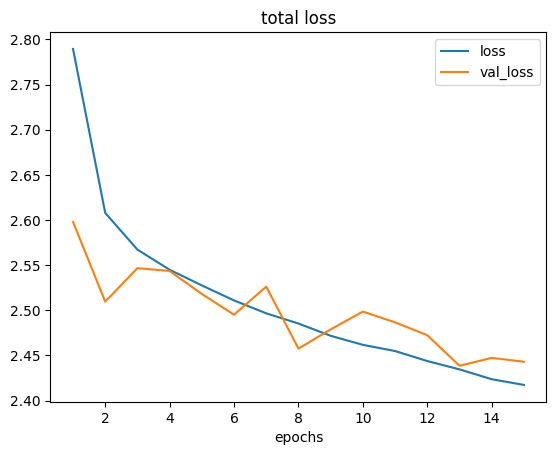

In [16]:
plt.plot(range(1, epochs + 1), history.history['loss'], label="loss")
plt.plot(range(1, epochs + 1), history.history['val_loss'], label="val_loss")
plt.xlabel("epochs")
plt.title("total loss")

plt.legend()
plt.show()

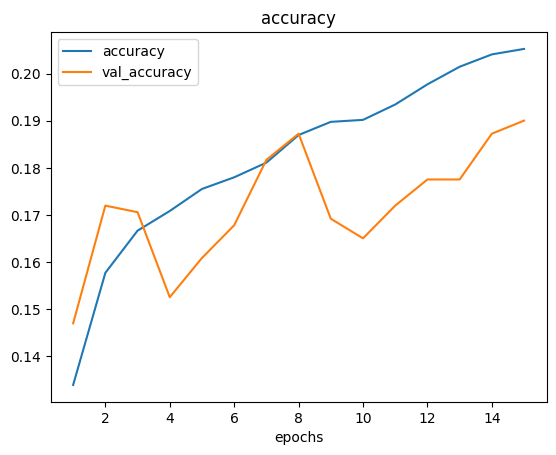

In [17]:
plt.plot(range(1, epochs + 1), history.history['accuracy'], label="accuracy")
plt.plot(range(1, epochs + 1), history.history['val_accuracy'], label="val_accuracy")
plt.xlabel("epochs")
plt.title("accuracy")

plt.legend()
plt.show()

In [18]:
train_preds = model.predict(train_dataset)
test_preds = model.predict(test_dataset)

12/12 [==============================] - 1s 71ms/step


In [19]:
train_preds_nums = [np.argmax(x_) for x_ in train_preds]
test_preds_nums = [np.argmax(x_) for x_ in test_preds]
train_true_nums = y_train_
test_true_nums = y_test_

In [20]:
def calculate_accuracy(actual_labels, predicted_labels):
    correct_predictions = sum(1 for actual, predicted in zip(actual_labels, predicted_labels) if actual == predicted)
    total_predictions = len(actual_labels)
    accuracy = correct_predictions / total_predictions
    return accuracy


def draw_pred_lines(y_pred, y_real):
    drawing_df = pd.DataFrame({"Pred": y_pred, "Real": y_real})
    drawing_df = drawing_df.sort_values("Real").reset_index(drop=True)

    for key_, val_ in drawing_df.items():
        plt.plot(range(len(val_)), val_, label=key_)

    plt.xlabel("No")
    plt.ylabel("Redexes count")
    plt.title("Pred vs Real Step Time")
    plt.legend()
    plt.show()

Train accuracy: 0.21683055788901517


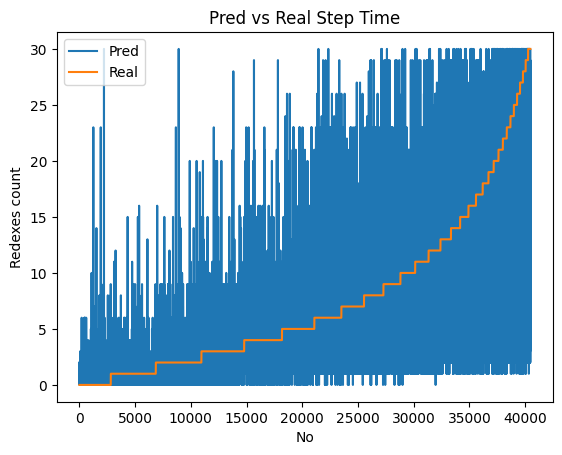

In [21]:
print("Train accuracy:", calculate_accuracy(train_true_nums, train_preds_nums))
draw_pred_lines(train_preds_nums, train_true_nums)

Test accuracy: 0.1900138696255201


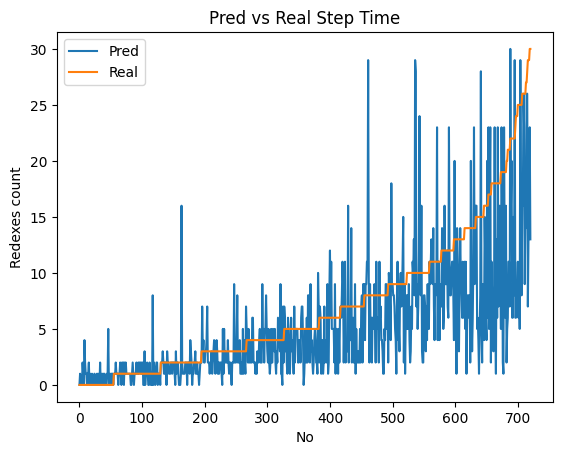

In [22]:
print("Test accuracy:", calculate_accuracy(test_true_nums, test_preds_nums))
draw_pred_lines(test_preds_nums, test_true_nums)

In [23]:
def draw_pred_scatter(y_pred, y_real):
    plt.scatter(y_real, y_pred, s=3)
    plt.plot([0, 30], [0, 30], color='gray', linestyle='--')

    plt.xlabel("Real reduction time")
    plt.ylabel("Predicted time")
    plt.title("Pred vs Real Reduction time")
    plt.show()

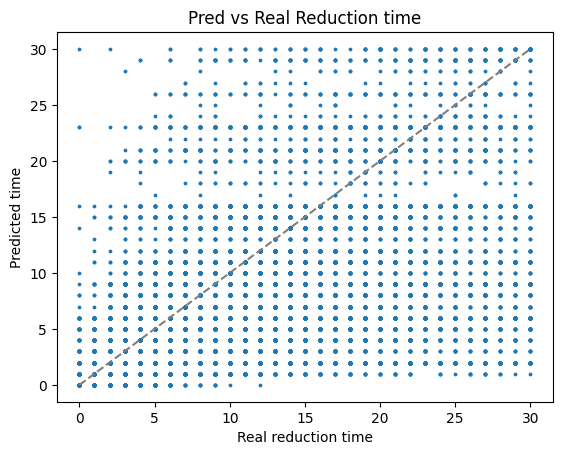

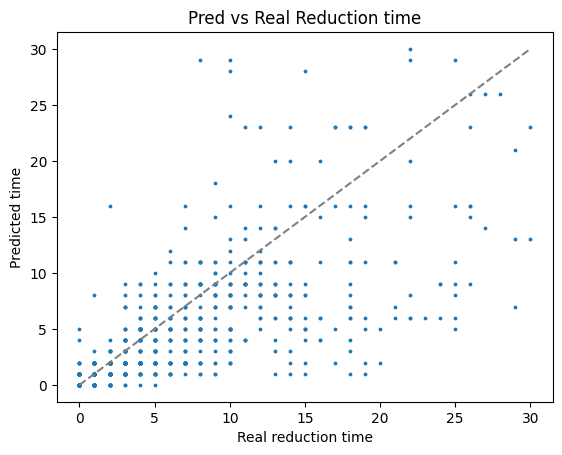

In [24]:
draw_pred_scatter(train_preds_nums, train_true_nums)
draw_pred_scatter(test_preds_nums, test_true_nums)

In [25]:
epochs = 15
history = model.fit(train_dataset, validation_data=test_dataset, epochs=epochs)

Epoch 1/15
633/633 [==============================] - 98s 155ms/step - loss: 2.4049 - accuracy: 0.2098 - val_loss: 2.4229 - val_accuracy: 0.1914
Epoch 2/15
633/633 [==============================] - 98s 155ms/step - loss: 2.3989 - accuracy: 0.2080 - val_loss: 2.4252 - val_accuracy: 0.1831
Epoch 3/15
633/633 [==============================] - 98s 155ms/step - loss: 2.3910 - accuracy: 0.2148 - val_loss: 2.4516 - val_accuracy: 0.1692
Epoch 4/15
633/633 [==============================] - 99s 156ms/step - loss: 2.3837 - accuracy: 0.2171 - val_loss: 2.4288 - val_accuracy: 0.1789
Epoch 5/15
633/633 [==============================] - 99s 156ms/step - loss: 2.3744 - accuracy: 0.2182 - val_loss: 2.4561 - val_accuracy: 0.1761
Epoch 6/15
633/633 [==============================] - 99s 156ms/step - loss: 2.3647 - accuracy: 0.2194 - val_loss: 2.4167 - val_accuracy: 0.1942
Epoch 7/15
633/633 [==============================] - 97s 154ms/step - loss: 2.3568 - accuracy: 0.2243 - val_loss: 2.4662 - val_ac

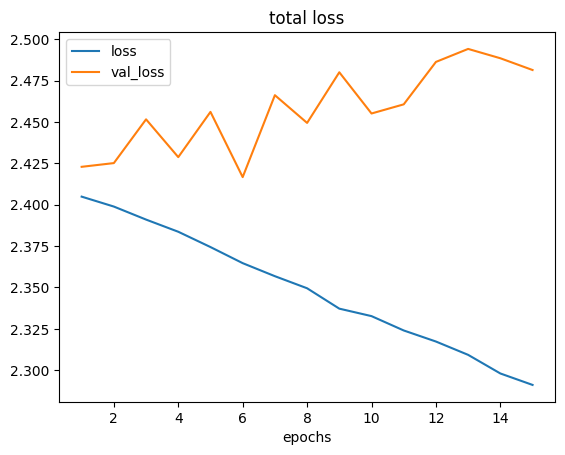

In [26]:
plt.plot(range(1, epochs + 1), history.history['loss'], label="loss")
plt.plot(range(1, epochs + 1), history.history['val_loss'], label="val_loss")
plt.xlabel("epochs")
plt.title("total loss")

plt.legend()
plt.show()

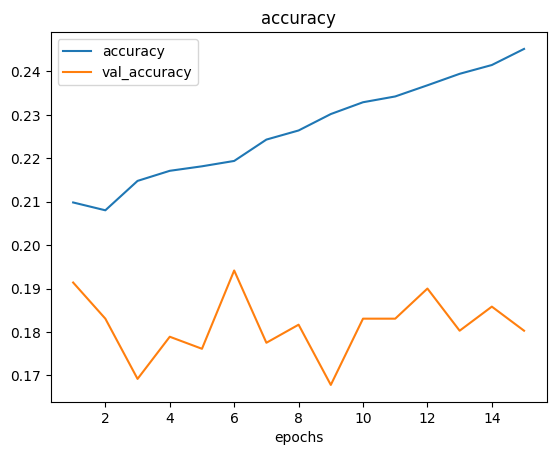

In [27]:
plt.plot(range(1, epochs + 1), history.history['accuracy'], label="accuracy")
plt.plot(range(1, epochs + 1), history.history['val_accuracy'], label="val_accuracy")
plt.xlabel("epochs")
plt.title("accuracy")

plt.legend()
plt.show()

In [28]:
train_preds = model.predict(train_dataset)
test_preds = model.predict(test_dataset)
train_preds_nums = [np.argmax(x_) for x_ in train_preds]
test_preds_nums = [np.argmax(x_) for x_ in test_preds]
train_true_nums = y_train_
test_true_nums = y_test_

12/12 [==============================] - 1s 53ms/step


Train accuracy: 0.268443939319069


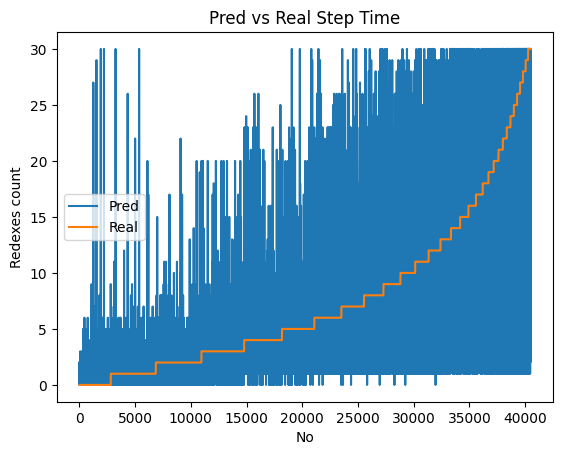

Test accuracy: 0.18030513176144244


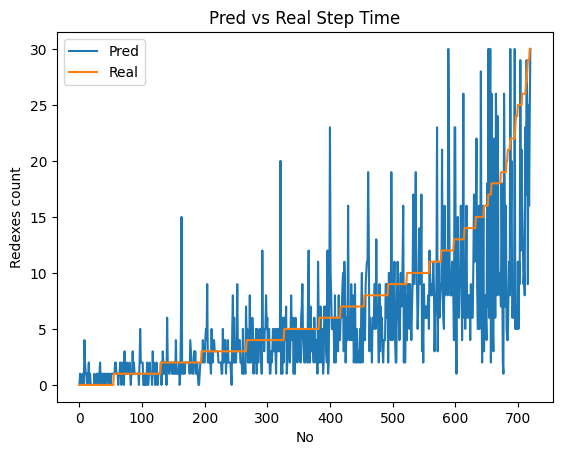

In [29]:
print("Train accuracy:", calculate_accuracy(train_true_nums, train_preds_nums))
draw_pred_lines(train_preds_nums, train_true_nums)
print("Test accuracy:", calculate_accuracy(test_true_nums, test_preds_nums))
draw_pred_lines(test_preds_nums, test_true_nums)

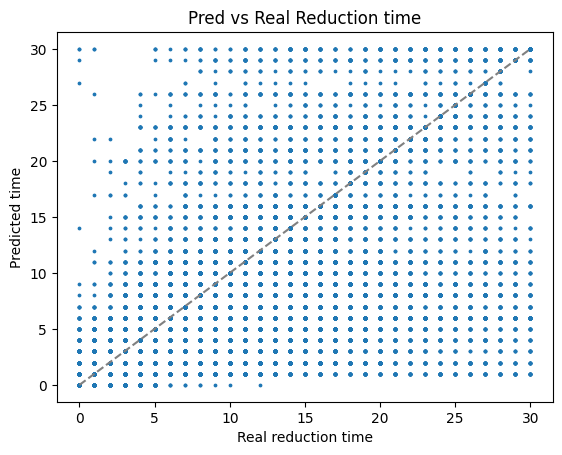

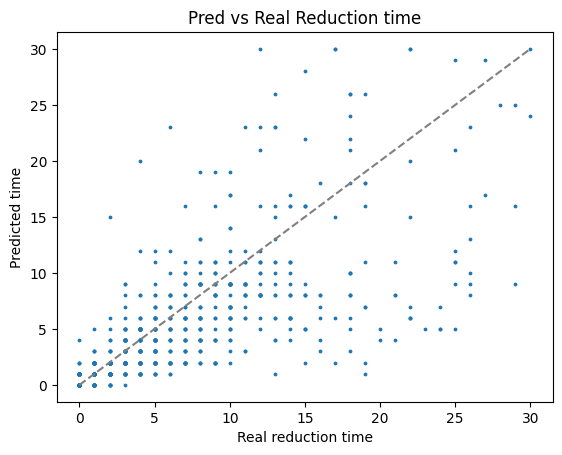

In [30]:
draw_pred_scatter(train_preds_nums, train_true_nums)
draw_pred_scatter(test_preds_nums, test_true_nums)

In [31]:
epochs = 15
history = model.fit(train_dataset, validation_data=test_dataset, epochs=epochs)

Epoch 1/15
633/633 [==============================] - 100s 157ms/step - loss: 2.2826 - accuracy: 0.2510 - val_loss: 2.4688 - val_accuracy: 0.1775
Epoch 2/15
633/633 [==============================] - 99s 157ms/step - loss: 2.2746 - accuracy: 0.2505 - val_loss: 2.4846 - val_accuracy: 0.1817
Epoch 3/15
633/633 [==============================] - 100s 157ms/step - loss: 2.2666 - accuracy: 0.2546 - val_loss: 2.4750 - val_accuracy: 0.1831
Epoch 4/15
633/633 [==============================] - 100s 158ms/step - loss: 2.2609 - accuracy: 0.2555 - val_loss: 2.5158 - val_accuracy: 0.1803
Epoch 5/15
633/633 [==============================] - 99s 157ms/step - loss: 2.2530 - accuracy: 0.2575 - val_loss: 2.5063 - val_accuracy: 0.1803
Epoch 6/15
633/633 [==============================] - 99s 156ms/step - loss: 2.2439 - accuracy: 0.2573 - val_loss: 2.5056 - val_accuracy: 0.1748
Epoch 7/15
633/633 [==============================] - 99s 156ms/step - loss: 2.2326 - accuracy: 0.2641 - val_loss: 2.5198 - val

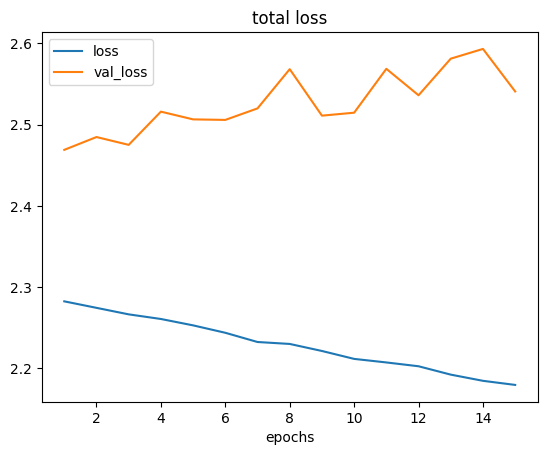

In [32]:
plt.plot(range(1, epochs + 1), history.history['loss'], label="loss")
plt.plot(range(1, epochs + 1), history.history['val_loss'], label="val_loss")
plt.xlabel("epochs")
plt.title("total loss")

plt.legend()
plt.show()

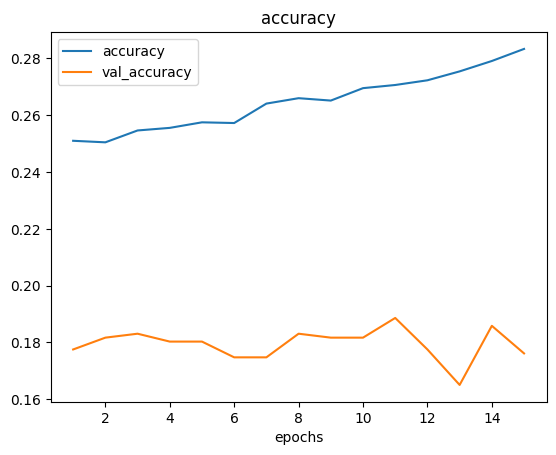

In [33]:
plt.plot(range(1, epochs + 1), history.history['accuracy'], label="accuracy")
plt.plot(range(1, epochs + 1), history.history['val_accuracy'], label="val_accuracy")
plt.xlabel("epochs")
plt.title("accuracy")

plt.legend()
plt.show()

In [34]:
train_preds = model.predict(train_dataset)
test_preds = model.predict(test_dataset)
train_preds_nums = [np.argmax(x_) for x_ in train_preds]
test_preds_nums = [np.argmax(x_) for x_ in test_preds]
train_true_nums = y_train_
test_true_nums = y_test_

12/12 [==============================] - 1s 53ms/step


Train accuracy: 0.31882195977664674


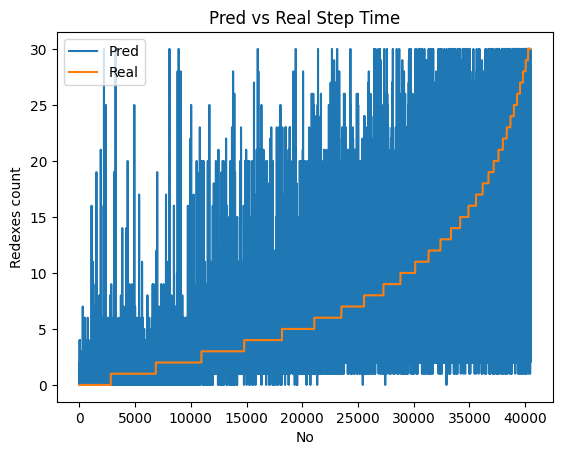

Test accuracy: 0.17614424410540916


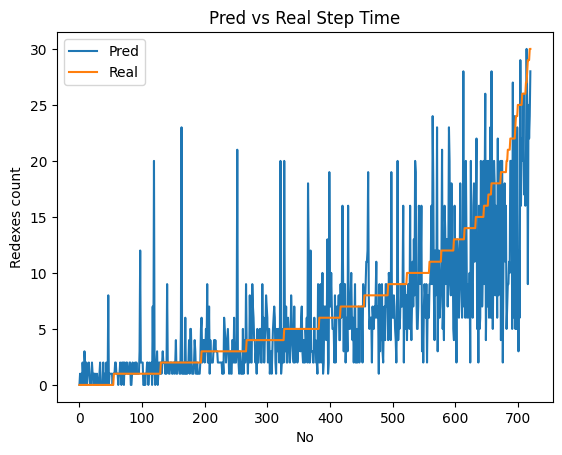

In [35]:
print("Train accuracy:", calculate_accuracy(train_true_nums, train_preds_nums))
draw_pred_lines(train_preds_nums, train_true_nums)
print("Test accuracy:", calculate_accuracy(test_true_nums, test_preds_nums))
draw_pred_lines(test_preds_nums, test_true_nums)

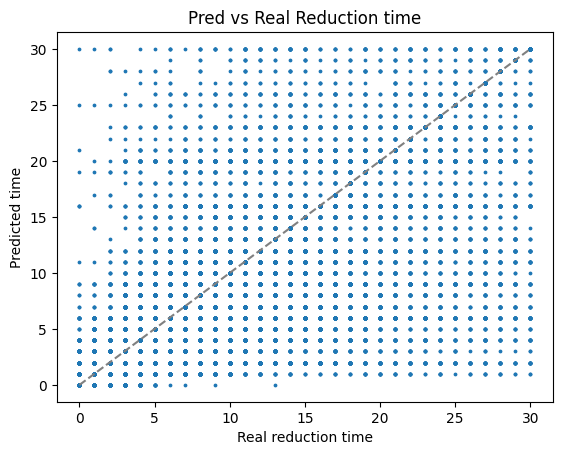

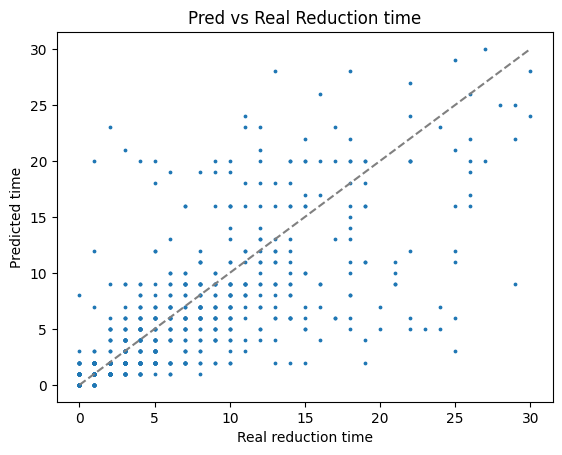

In [36]:
draw_pred_scatter(train_preds_nums, train_true_nums)
draw_pred_scatter(test_preds_nums, test_true_nums)

In [37]:
epochs = 15
history = model.fit(train_dataset, validation_data=test_dataset, epochs=epochs)

Epoch 1/15
633/633 [==============================] - 99s 156ms/step - loss: 2.1726 - accuracy: 0.2807 - val_loss: 2.5668 - val_accuracy: 0.1748
Epoch 2/15
633/633 [==============================] - 99s 157ms/step - loss: 2.1634 - accuracy: 0.2841 - val_loss: 2.5853 - val_accuracy: 0.1734
Epoch 3/15
633/633 [==============================] - 99s 157ms/step - loss: 2.1572 - accuracy: 0.2869 - val_loss: 2.5492 - val_accuracy: 0.1734
Epoch 4/15
633/633 [==============================] - 100s 157ms/step - loss: 2.1511 - accuracy: 0.2912 - val_loss: 2.6038 - val_accuracy: 0.1623
Epoch 5/15
633/633 [==============================] - 99s 157ms/step - loss: 2.1451 - accuracy: 0.2908 - val_loss: 2.5969 - val_accuracy: 0.1914
Epoch 6/15
633/633 [==============================] - 100s 157ms/step - loss: 2.1339 - accuracy: 0.2938 - val_loss: 2.5758 - val_accuracy: 0.1928
Epoch 7/15
633/633 [==============================] - 100s 157ms/step - loss: 2.1300 - accuracy: 0.2957 - val_loss: 2.6134 - val

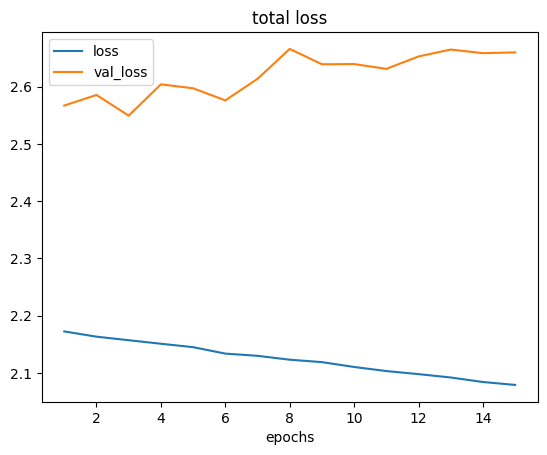

In [38]:
plt.plot(range(1, epochs + 1), history.history['loss'], label="loss")
plt.plot(range(1, epochs + 1), history.history['val_loss'], label="val_loss")
plt.xlabel("epochs")
plt.title("total loss")

plt.legend()
plt.show()

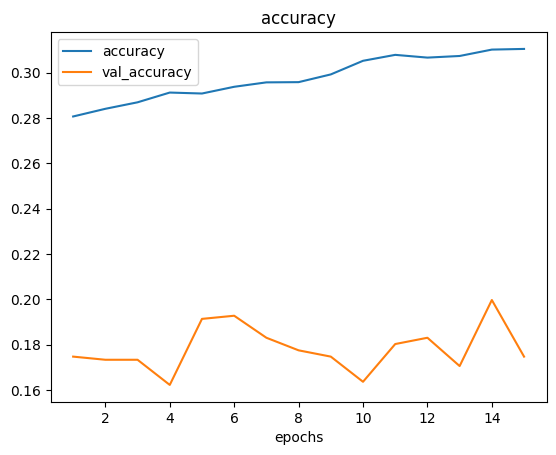

In [39]:
plt.plot(range(1, epochs + 1), history.history['accuracy'], label="accuracy")
plt.plot(range(1, epochs + 1), history.history['val_accuracy'], label="val_accuracy")
plt.xlabel("epochs")
plt.title("accuracy")

plt.legend()
plt.show()

In [40]:
train_preds = model.predict(train_dataset)
test_preds = model.predict(test_dataset)
train_preds_nums = [np.argmax(x_) for x_ in train_preds]
test_preds_nums = [np.argmax(x_) for x_ in test_preds]
train_true_nums = y_train_
test_true_nums = y_test_

12/12 [==============================] - 1s 56ms/step


Train accuracy: 0.3564510549982705


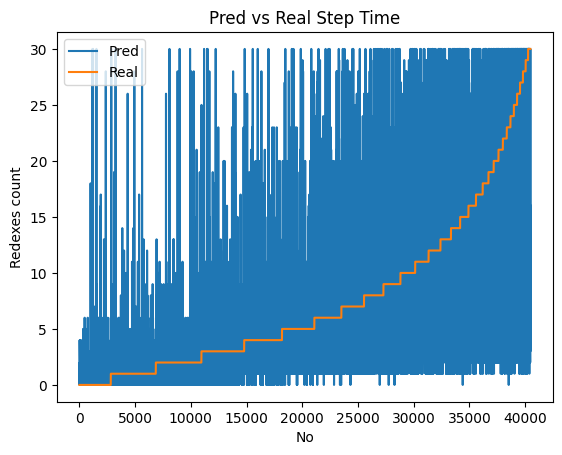

Test accuracy: 0.17475728155339806


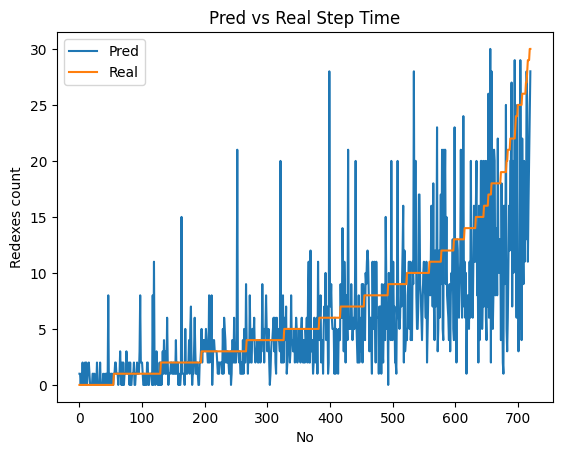

In [41]:
print("Train accuracy:", calculate_accuracy(train_true_nums, train_preds_nums))
draw_pred_lines(train_preds_nums, train_true_nums)
print("Test accuracy:", calculate_accuracy(test_true_nums, test_preds_nums))
draw_pred_lines(test_preds_nums, test_true_nums)

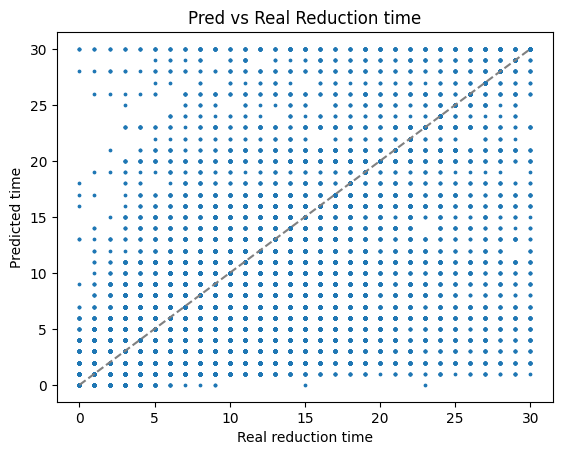

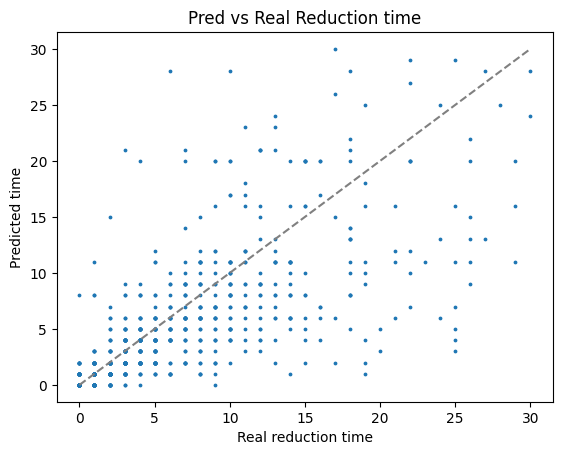

In [42]:
draw_pred_scatter(train_preds_nums, train_true_nums)
draw_pred_scatter(test_preds_nums, test_true_nums)